# Predator-prey model

In [1]:
#don't need first two lines if using installed version of EasyABM
using Pkg, Revise
Pkg.activate(joinpath(@__DIR__, "../.."))
using EasyABM

  Activating project at `~/Documents/EasyABM`


WebIO._IJuliaInit()

## Step 1: Create Agents and Model

We create 200 agents all of type `sheep` to begin with. Our model parameters are 

* `max_energy` : The maximum energy that an agent (sheep or wolf) can have. 
* `wolf_birth_rate` : Probability of a wolf agent to reproduce once its energy is greater than max_energy/2.  
* `sheep_birth_rate` : Probability of a sheep agent to reproduce once its energy is greater than max_energy/2. 
* `wolves_kill_ability` : The probability of a wolf to kill a neighboring sheep.
* `grass_grow_prob` : The probability of one unit of grass growing on a patch at a given timestep.
* `max_grass` : Max grass a patch can have.
* `initial_wolf_percent` : The percent of agents which are wolf initially. 

In [2]:
@enum agenttype sheep wolf
agents = grid_2d_agents(200, pos = Vect(1,1), color = cl"white", atype = sheep, 
    energy = 10.0, keeps_record_of=Set([:pos, :energy ]))
model = create_2d_model(agents, 
    size = (20,20), #space size
    agents_type = Mortal, # agents are mortal, can take birth or die
    space_type = NPeriodic, # nonperiodic space
    #below are all the model parameters
    max_energy = 50, 
    wolf_birth_rate = 0.01,
    sheep_birth_rate = 0.1,
    wolves_kill_ability = 0.2,
    max_grass = 5,
    initial_wolf_percent = 0.2,
    grass_grow_prob = 0.2)

EasyABM SpaceModel2D{EasyABM.MortalType, Int64, EasyABM.NPeriodicType}: In a EasyABM.MortalType model agents can take birth or die.


## Step 2: Initialise the model

In the second step we initialise the patches and agents by defining `initialiser!` function and sending it as an argument to `init_model!`. In the `initialiser!` function we randomly set amount of grass and accordingly color of each patch. We also set a fraction `initial_wolf_percent` of agents to be of type wolf. We set color of sheeps to white and that of wolves to black. We also randomly set the energy and positions of agents. In the `init_model!` function through argument `props_to_record` we tell EasyABM to record the color property of patches during model run.

In [3]:
function initialiser!(model)
    max_grass = model.parameters.max_grass
    for j in 1:model.size[2]
        for i in 1:model.size[1]
            grass = rand(1:max_grass)
            model.patches[i,j].grass = grass
            hf = Int(ceil(max_grass/2))
            model.patches[i,j].color = grass > hf ? cl"green" : (grass > 0 ? cl"blue" : cl"grey")
        end
    end
    for agent in model.agents
        if rand()< model.parameters.initial_wolf_percent 
            agent.atype = wolf
            agent.color = cl"black"
        else
            agent.atype = sheep
            agent.color = cl"white"
        end
        agent.energy = rand(1:model.parameters.max_energy)+0.0
        agent.pos = Vect(rand(1:model.size[1]), rand(1:model.size[2]))
    end
            
end

init_model!(model, initialiser = initialiser!, props_to_record = Dict("patches"=>Set([:color])))


## Step 3: Defining the step_rule! and running the model

In this step we implement the step logic of the predator prey model in the `step_rule!` function and run the model for 100 steps. 

In [4]:
function change_pos!(agent)
    dx = rand(-1:1)
    dy = rand(-1:1)
    agent.pos += Vect(dx, dy)
end

function reproduce!(agent, model)
    new_agent = create_similar(agent)
    agent.energy = agent.energy/2
    new_agent.energy = agent.energy
    add_agent!(new_agent, model)
end

function eat_sheep!(wolf, sheep, model)
    kill_agent!(sheep, model) 
    wolf.energy+=1
end


function act_asa_wolf!(agent, model)
    if !(is_alive(agent))
        return
    end
    energy = agent.energy
    if energy > 0.5*model.parameters.max_energy
        if rand()<model.parameters.wolf_birth_rate
            reproduce!(agent, model)
        end
    elseif energy > 0 
        nbrs = collect(neighbors_moore(agent, model, 1))
        n = length(nbrs)
        if n>0
            nbr = nbrs[rand(1:n)]
            if (nbr.atype == sheep)&&(is_alive(nbr))
                ability = model.parameters.wolves_kill_ability
                (rand()<ability)&&(eat_sheep!(agent, nbr, model))
            end
        end
        change_pos!(agent)
    else
        kill_agent!(agent, model)
    end
end

function act_asa_sheep!(agent, model)
    if !(is_alive(agent))
        return
    end
    energy = agent.energy
    if energy >0.5* model.parameters.max_energy
        if rand()<model.parameters.sheep_birth_rate
            reproduce!(agent, model)
        end
        change_pos!(agent)
    elseif energy > 0 
        patch = get_grid_loc(agent)
        grass = model.patches[patch...].grass
        if grass>0
            model.patches[patch...].grass-=1
            agent.energy +=1
        end
        change_pos!(agent)
    else
        kill_agent!(agent, model)
    end
end



function step_rule!(model)
    if model.max_id>800 # use some upper bound on max agents to avoid system hang
        return
    end
    for agent in model.agents
        if agent.atype == wolf
            act_asa_wolf!(agent,model)
        end
        if agent.atype == sheep
            act_asa_sheep!(agent, model)
        end
    end
    for j in 1:model.size[2]
        for i in 1:model.size[1]
            patch = model.patches[i,j]
            grass = patch.grass
            max_grass = model.parameters.max_grass 
            if grass < max_grass
                if rand()<model.parameters.grass_grow_prob
                    patch.grass+=1
                    hf = Int(ceil(max_grass/2))
                    patch.color = grass > hf ? cl"green" : (grass > 0 ? cl"yellow" : cl"grey")
                end
            end
        end
    end
end

run_model!(model, steps=100, step_rule = step_rule! )

## Step 4: Visualisation

In order to draw the model at a specific frame, say 4th, one can use

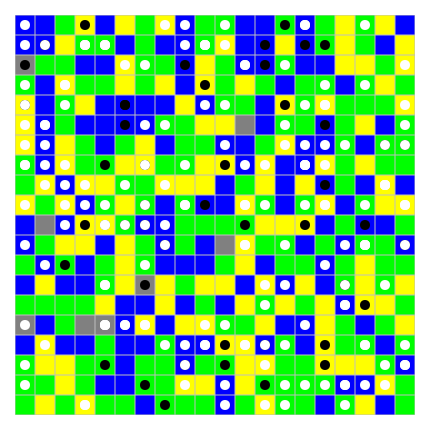

In [5]:
draw_frame(model, frame = 4, show_patches=true)

 If one wants to see the animation of the model run, it can be done as 

In [6]:
animate_sim(model, show_patches=true)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["time"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 101, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable(0), nothing), "index" => (Observable(51), nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/home/dushya/.julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/home/dushya/.julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/home/dushya/.julia/packages/InteractBase/LJXv3/src/../assets/all.js"), WebIO.Asset("css", nothing, "/home/dushya/.julia/packages/InteractBase/LJXv3/src/../assets/style.css"), WebIO.Asset("css", nothing, "/home/dushya/.julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Base.GenericCondition{ReentrantLock}(Base.IntrusiveLinkedList{Task}(Task (runnable) @0x00007fb4f6270e20, Task (runnable) @0x00007fb4f6270e20), ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (2, 140415852067776, 140415852067776)))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n

After defining the `step_rule!` function we can also choose to create an interactive application (which currently works in Jupyter with WebIO installation) as 

In [7]:
create_interactive_app(model, initialiser= initialiser!,
    step_rule= step_rule!,
    model_controls=[
        (:wolf_birth_rate, "slider", 0:0.01:1.0),
        (:sheep_birth_rate, "slider", 0.01:0.01:1.0),
        (:initial_wolf_percent, "slider", 0.01:0.01:0.9),
        (:wolves_kill_ability, "slider", 0.01:0.01:1.0),
        (:grass_grow_prob, "slider", 0.01:0.01:0.5)
        ], 
    agent_plots=Dict("sheep"=> agent-> agent.atype == sheep ? 1 : 0, 
        "wolf"=> agent-> agent.atype == wolf ? 1 : 0),
    frames=200, show_patches=true)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["time"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 200, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable(0), nothing), "index" => (Observable(1), nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/home/dushya/.julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/home/dushya/.julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/home/dushya/.julia/packages/InteractBase/LJXv3/src/../assets/all.js"), WebIO.Asset("css", nothing, "/home/dushya/.julia/packages/InteractBase/LJXv3/src/../assets/style.css"), WebIO.Asset("css", nothing, "/home/dushya/.julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Base.GenericCondition{ReentrantLock}(Base.IntrusiveLinkedList{Task}(Task (runnable) @0x00007fb4b769f850, Task (runnable) @0x00007fb4b769f850), ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (8, 0, 141733920768)))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n  


## Step 4: Fetch Data 

We can fetch the number of wolves and sheeps at each time step as follows. 

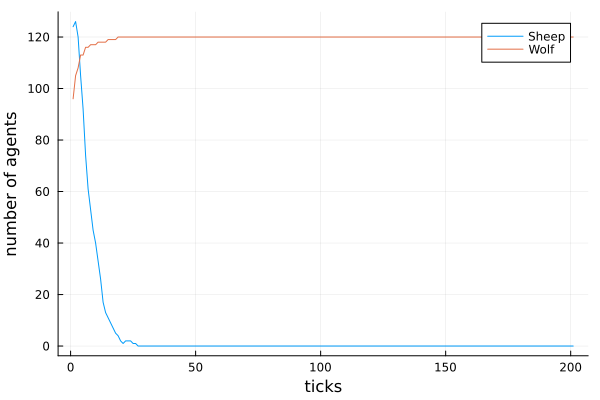

Row,Sheep,Wolf
,Int64,Int64
1,124,96
2,126,105
3,120,108
4,105,113
5,92,113
6,74,116
7,61,116
8,53,117
9,45,117


In [8]:
df = get_nums_agents(model, agent-> agent.atype == sheep, 
    agent->agent.atype == wolf, labels=["Sheep", "Wolf"], 
    plot_result = true)

Individual agent data recorded during model run can be obtained as

In [9]:
df = get_agent_data(model.agents[2], model).record

Row,energy,pos
,Float64?,Vect…?
1,18.0,"(20, 15)\n"
2,18.0,"(20, 16)\n"
3,18.0,"(20, 16)\n"
4,18.0,"(19, 17)\n"
5,18.0,"(18, 16)\n"
6,18.0,"(17, 15)\n"
7,18.0,"(18, 14)\n"
8,18.0,"(18, 13)\n"
9,18.0,"(18, 14)\n"


In [10]:
model.agents[1]

Agent2D:
 pos :(20, 20)

 color: RGBA{N0f8}(0.0,0.0,0.0,1.0)

 atype: wolf
 energy: 14.0
 size: 0.25
 orientation: 0.0
 shape: circle
